<a href="https://colab.research.google.com/github/yishengli/GraphMiningNotebooks/blob/master/Gomez_Li_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-igraph

     |████████████████████████████████| 3.2 MB 5.4 MB/s 


In [ ]:
pip install haversine

In [ ]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
from numpy import linalg as la
from scipy.sparse import csr_matrix
from numpy.linalg import matrix_power
from itertools import combinations
from haversine import haversine as hv
from collections import Counter
import random 
from scipy.optimize import curve_fit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Problem 2

Following the same premises as with the European grid network, the code to  clean and process the data, as well as building the undirected graph is:

In [ ]:
american_grid_edges_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GridNorthAmerica/gridkit_north_america-highvoltage-links.csv'
american_grid_nodes_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GridNorthAmerica/gridkit_north_america-highvoltage-vertices.csv'

In [ ]:
## Read links csv file - Grid North America
ENA = pd.read_csv(american_grid_edges_url)
ENA = ENA[['v_id_1','v_id_2']]
tup = [tuple(x) for x in ENA.values]
GNA = ig.Graph.TupleList(tup, directed = False)
GNA = GNA.simplify()

## Sorter index
idx = [int(i) for i in GNA.vs['name']]
sorterIndex_GNA = dict(zip(idx,range(len(idx))))

## Read vertices csv file and other attributes - Grid North America
VNA = pd.read_csv(american_grid_nodes_url)
VNA = VNA[['v_id','lon','lat','typ']]
VNA['Rank'] = VNA['v_id'].map(sorterIndex_GNA)
VNA.sort_values(['Rank'], ascending=[True],inplace=True)
VNA.dropna(inplace=True)

## Combining the two datasets
GNA.vs['longitude'] = list(VNA['lon'])
GNA.vs['latitude'] = list(VNA['lat'])
GNA.vs['type'] = list(VNA['typ'])
## Tuples with lat/lon
GNA.vs['layout'] = [(v['longitude'],v['latitude']) for v in GNA.vs()]
GNA.vs['size'] = 3
GNA.es['color'] = 'grey'
GNA.vs['color'] = 'black'

Below is the code to calculate the basic descriptive statistics included in Table 1.1 of the text book, but for the North America grid network:

In [ ]:
## Creating repeatable process
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
##Storing the same basic stats of table 1.1
Stats = []
Stats.append(['Grid North America'] + baseStats(GNA))
Stats_tab = pd.DataFrame(Stats,columns=['graph','# nodes','# edges',r'min degree',r'mean degree',r'median degree',
                            r'quant99 degree',r'max degree','diameter','# components','largest component',
                            '# isolates',r'Cglob',r'Cloc']).transpose()
Stats_tab

,0
graph,Grid North America
# nodes,16167
# edges,20242
min degree,1
mean degree,2.50411
median degree,2
quant99 degree,7
max degree,22
diameter,138
# components,34


# Problem 3

Below is the code to process the github graph, and to create the github ml subgraph:


In [ ]:
musae_git_target_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GitHubDevelopers/musae_git_target.csv'
musae_git_edges_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GitHubDevelopers/musae_git_edges.csv'

In [ ]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(musae_git_edges_url)
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## add some node features, here there are two class of nodes
## 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(musae_git_target_url)
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
#gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey' ## edge color

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


Now, the subgraphed is also subgraphed taking only the nodes with at least one edge, for computing purposes:

In [ ]:
## Create subgraph only with connected nodes
con_ml = gh_ml.subgraph_edges(gh_ml.get_edgelist(), delete_vertices = True)
## Number of nodes in 
print('Nodes of connected ml developers (at least one edge):',len(con_ml.vs()))

Nodes of connected ml developers (at least one edge): 7431


Following the procedure described in https://www.um.edu.mt/library/oar/bitstream/123456789/24439/1/powers%20of%20the%20adjacency%20matrix.pdf , the code to calculate the number of walks is:

3a

In [ ]:
## Adjacency matrix
adj_ml = con_ml.get_adjacency()
numadj_ml = np.array(adj_ml.data)

For computing purposes, walks of only length 3 will be calculated (takes about 3 hours to run), that is:

In [ ]:
## Calculating the number of walks
B = csr_matrix(numadj_ml).todense()
power3 = matrix_power(B,3)

In [ ]:
print('Walks of length 3: ', np.sum(power3)/2)

Walks of length 3:  17007495.0


Walks of length 5: 18087602377.0 (Note: The computation was performed on AWS.)

In [ ]:
##B = csr_matrix(numadj_ml).todense()
##power5 = matrix_power(B,5)
##print('Walks of length 5: ', np.sum(power5)/2)

Regarding the number of cycles of length 4 (induced, that is, without chords), let us first loop through all nodes to calculate all simple paths of up to length 4 starting and finishing on it 

3b

In [ ]:
paths = []
length = 4
number = len(con_ml.vs())
##for n1 in con_ml.vs()[0:number]:
##    for n2 in con_ml.vs()[0:number]:
## Loop through each node
for n1 in con_ml.vs():
    for n2 in con_ml.vs():
        ## Only when nodes are different
        if (n1 != n2):
            directpaths = con_ml.get_all_simple_paths(v = n2, to = n1, cutoff = 1)
            ## Identify if there's an edge between the nodes
            if (len(directpaths) > 0):
                ## Get all simple paths between the pair of up to length - 1
                pathsl = con_ml.get_all_simple_paths(v = n1, to = n2, cutoff = length - 1)
                if (len(pathsl) > 0):
                    for p in pathsl:
                        ## For every simple path of length
                        if (len(p) == length):
                            ## Generate subgraph
                            sb_ml_temp = con_ml.induced_subgraph(p)
                            edges_temp = sb_ml_temp.get_edgelist()
                            ## Validate if chordless (it should only have length edges)
                            if (len(edges_temp) == length):
                                p.append(p[0])
                                paths.append(p)

In [ ]:
print('Total evaluated chordless of length', length, 'cycles: ', len(paths))
print('Adjusted chordless cycles of length', length, ': ', len(paths)/(2*length))

Total evaluated chordless of length 4 cycles:  673280
Adjusted chordless cycles of length 4 :  84160.0


# Problem 4

In [ ]:
airport_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/Airports/connections.csv'
airportloc_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/Airports/airports_loc.csv'
airport_df = pd.read_csv(airport_url)
# airport_edges = airport_df[['orig_airport', 'dest_airport']].copy()
# air_edges_tuple = [tuple(x) for x in airport_edges.values]
air_gr = ig.Graph.TupleList(airport_df.values, 
                            weights = True, 
                            directed = True)
# This assumes that the first three columns of edges_df are respectively the source, 
# the target and the edge weight. 
# The names of the columns are irrelevant in this case.

4a

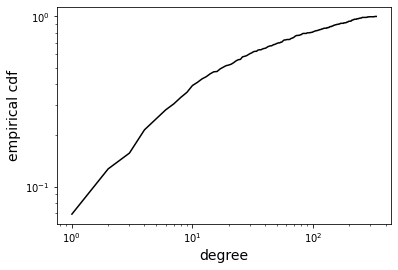

In [ ]:
deg = air_gr.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='black',label='Airport')
plt.yscale("log")
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);

4b

In [ ]:
deg_dict = dict(zip(air_gr.vs['name'], deg))
# deg_dict
print(air_gr.vs['name'][deg.index(max(deg))])

ATL


The busiest airport in terms of the total degree is Atlanta. 

4c

In [ ]:
components = air_gr.clusters()
components.summary()

'Clustering with 464 elements and 40 clusters'

4d

In [ ]:
## Sorter index
idx = [(i) for i in air_gr.vs['name']]
si = dict(zip(idx,range(len(idx))))

In [ ]:
## Read vertices csv file and other attributes - Grid North America
n_airport_df = pd.read_csv(airportloc_url)
n_airport_df['Rank'] = n_airport_df['airport'].map(si)
n_airport_df.sort_values(['Rank'], ascending=[True],inplace=True)
n_airport_df.dropna(inplace=True)

In [ ]:
## Combining the two datasets
air_gr.vs['longitude'] = list(n_airport_df['lon'])
air_gr.vs['latitude'] = list(n_airport_df['lat'])
air_gr.vs['state'] = list(n_airport_df['state'])
air_gr.vs['city'] = list(n_airport_df['city'])
## Tuples with lat/lon
air_gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in air_gr.vs()]

In [ ]:
## build the California subgraph
air_ca = air_gr.subgraph([v for v in air_gr.vs() if v['state']=='CA'])

In [ ]:
print('Total California Airport nodes:',air_ca.vcount())
print('Total Isolate California Airport nodes:',sum([x==0 for x in air_ca.degree()]))

Total California Airport nodes: 31
Total Isolate California Airport nodes: 9


# Problem 5

In [ ]:
eu_grid_edges_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GridEurope/gridkit_europe-highvoltage-links.csv'
eu_grid_nodes_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GridEurope/gridkit_europe-highvoltage-vertices.csv'
eu_edges_df = pd.read_csv(eu_grid_edges_url)
edges = eu_edges_df[['v_id_1', 'v_id_2']].copy()
X = pd.read_csv(eu_grid_nodes_url)

In [ ]:
## read edge list for the grid network and build undirected graph
edges_tuple = [tuple(x) for x in edges.values]
gr = ig.Graph.TupleList(edges_tuple, directed = False)
gr = gr.simplify()

## read the vertices along with some of the attributes
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

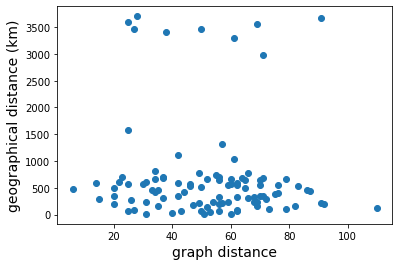

In [ ]:
sg = gr.clusters().giant()
v_lst = [i for i in range(sg.vcount())]
random_pairs = random.sample(list(combinations(v_lst, 2)), 100)
path_lst = [sg.shortest_paths(random_pairs[i][0], random_pairs[i][1])[0][0] for i in range(len(random_pairs))]
dist_lst = [hv(sg.vs[random_pairs[i][0]]['layout'], sg.vs[random_pairs[i][1]]['layout']) for i in range(len(random_pairs))]

plt.scatter(path_lst, dist_lst, marker='o')
plt.xlabel('graph distance',fontsize=14)
plt.ylabel('geographical distance (km)',fontsize=14);

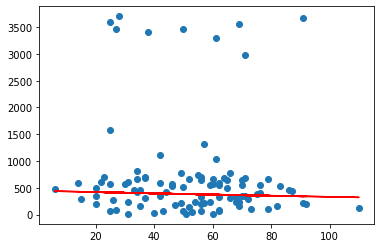

In [ ]:
x_data = np.array(path_lst)   
y_data = np.array(dist_lst)     
log_y_data = np.log(y_data)             
# log_x_data = np.log(x_data)   
curve = np.polyfit(x_data, log_y_data, 1)
a, b = curve
y = np.exp(b) * np.exp(a*x_data)
plt.scatter(x_data, y_data)
  
# Best fit in red
plt.plot(x_data, y, 'r')